In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from analysis_utils import *

# RIN criticality analysis

### Subject of analysis

In [3]:
prot = "7KVE_relaxed"
str_uni = "unidirectional"
unidirectional = True
str_inter = ""
filter_inter = False
path_data = "../data/igraph"

In [4]:
results_figs_path = "../figures/results"

### Dataset with everything!

Mutations, graph features, structural features, conservation score.

We'll use `df_mgsc` only in the first, pre-processing step.

In [5]:
df_mgsc, df_structure, df_conservation = read_all_data(prot = prot,
                                                       str_uni = str_uni, unidirectional = unidirectional,
                                                       str_inter = str_inter, filter_inter = filter_inter)


Graph is simple (no loops or multiple edges)

Everythings all right with the number of features!


### Graph features of RIN

This has the full RIN

In [6]:
graph_features_path = os.path.join(path_data, 'out', f"{prot}_graph_features_{str_uni}{str_inter}.csv")

df_graph_features = pd.read_csv(graph_features_path)

df_graph_features.shape

(1374, 8)

**Important preprocessing: zero betweenness**

Let's look at the whole RIN to identify and remove nodes with zero betweenness. That's important because we'll calculate log-betweenness as feature, so nodes with zero betweenness must be dropped, so that -inf won't happen.

In [7]:
# nodes with 0 betweenness -- expected

df_graph_features.query("betweenness == 0").shape

(48, 8)

In [8]:
zero_betweenness = df_graph_features.query("betweenness == 0")["node"].sort_values().unique().tolist()

print(zero_betweenness)

[1, 14, 21, 24, 25, 50, 79, 101, 107, 128, 172, 178, 202, 302, 307, 338, 339, 382, 427, 434, 439, 450, 467, 511, 548, 570, 577, 641, 665, 676, 686, 697, 704, 712, 1536, 1538, 1599, 1601, 1893, 1916, 1926, 1955, 1957, 1975, 1994, 2064, 2116, 2143]


In [9]:
nodes_zero_betw = get_nodes_with_zero_betweenness_formated(df_graph_features,
                                                           prot, 
                                                           str_uni,
                                                           str_inter)

print(*nodes_zero_betw, sep = ", ")

There are 48 nodes with zero betweenness in the RIN!

Ala1, Ser14, Pro21, Ser24, Ser25, Pro50, Asp79, Leu101, Ala107, Glu128, Glu172, Thr178, Leu202, Pro302, Asn307, Val338, Ile339, Asn382, Tyr427, Ser434, Arg439, Gly450, Glu467, Ala511, Asp548, Thr570, Asp577, Ser641, Tyr665, Met676, Glu686, Asp697, Ala704, Arg712, Pro1536, Asn1538, Thr1599, Thr1601, Ser1893, Ser1916, Ala1926, His1955, Leu1957, Asn1975, Ser1994, Trp2064, Leu2116, Ser2143


### Disconnected residues

Due to errors in the Cryo-EM structure determination.

<div>
   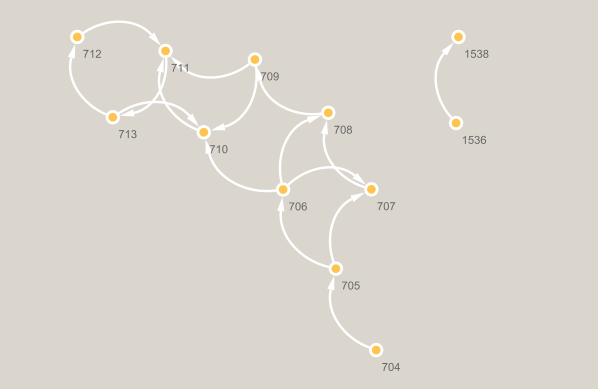
</div>

First of all, we'll see if these residues which are disconnected appear in the mutations dataset:

In [10]:
nodes_in_mutations_dataset = df_mgsc["node"].unique().tolist()

In [11]:
disconnected_res = [704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 
                    1536, 1538]

nodes_disconnected = get_disconnected_nodes_formated(df_graph_features, 
                                                     disconnected_res, 
                                                     prot, 
                                                     str_uni, 
                                                     str_inter)

print(*nodes_disconnected, sep = ", ")

There are 12 disconnected nodes in the RIN!

Ala704, Ala705, Leu706, Gly707, Ile708, Arg709, Ser710, Phe711, Arg712, Asn713, Pro1536, Asn1538


In [12]:
len(disconnected_res)

12

In [13]:
# both zero betweenness and disconected
[x for x in disconnected_res if x in zero_betweenness]

[704, 712, 1536, 1538]

In [14]:
[x for x in disconnected_res if x in nodes_in_mutations_dataset]

[]

Great! None of this are in the mutations dateset, so it's safe to drop them!

In [15]:
df_graph_features = df_graph_features.query(f"node not in {disconnected_res}").copy()

_________


Now, let's see if the other ones with 0 betweenes are in the mutations dataset:

In [16]:
[x for x in df_graph_features.query("betweenness == 0")["node"].values if x in nodes_in_mutations_dataset]

[]

Also none! That's great! So it's also safe to drop them from the analysis!

In [17]:
df_graph_features = df_graph_features.query("betweenness != 0").copy()

In [18]:
# should be empty!
df_graph_features.query("betweenness == 0")

,node,degree,betweenness,closeness,burt,authority,page_rank,k_core


____

In [19]:
# reading again, all in one single cell, to make clearer

graph_features_path = os.path.join(path_data, 'out', f"{prot}_graph_features_{str_uni}{str_inter}.csv")

df_graph_features = pd.read_csv(graph_features_path)

###############################################

df_graph_features = df_graph_features.query("betweenness != 0").copy()

###############################################

disconnected_res = [704, 705, 706, 707, 708, 709, 710, 711, 712, 713, 
                    1536, 1538]

df_graph_features = df_graph_features.query(f"node not in {disconnected_res}").copy()

###############################################

# log betweenness
df_graph_features["log_betweenness"] = np.log10(df_graph_features["betweenness"])

print(df_graph_features.shape)

(1318, 9)


# Now we'll start the analysis!

### Graph features correlations


                          Correlation method: pearson                           



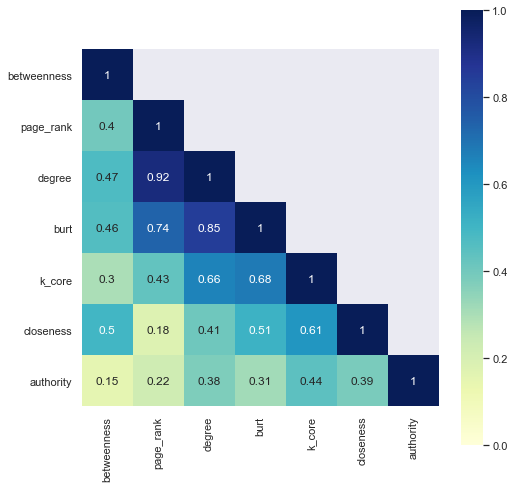


                          Correlation method: kendall                           



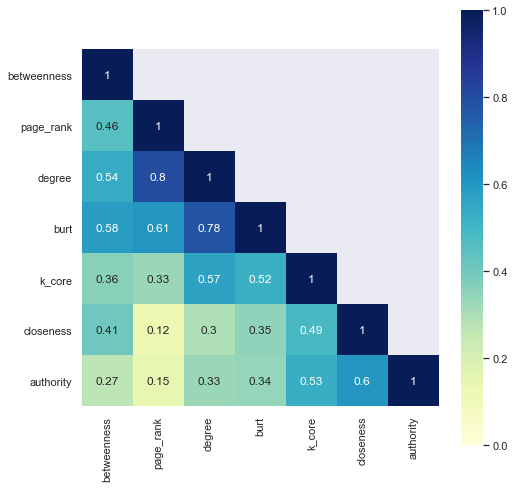


                          Correlation method: spearman                          



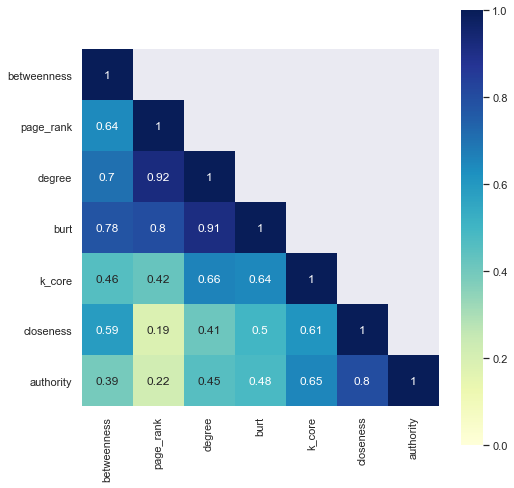

In [20]:
graph_features = ["betweenness", "page_rank", "degree", "burt", "k_core", "closeness", "authority"]

# for the whole RIN
for method in "pearson kendall spearman".split():
    
    print(f"\n{'='*80}\n{f'Correlation method: {method}'.center(80)}\n{'='*80}\n")
    
    corr_graph_features = df_graph_features[graph_features].corr(method=method)

    plt.figure(figsize=(8, 8))

    mask = np.triu(np.ones_like(corr_graph_features, dtype=bool))

    # to show diagonal too
    np.fill_diagonal(mask, False)

    # absolute value of correlations!
    sns.heatmap(corr_graph_features.applymap(lambda x: abs(x)), 
                annot=True, 
                vmin=0, 
                vmax=1, 
                square=True, 
                cmap="YlGnBu",
                mask=mask)
    
    plt.savefig(f"{results_figs_path}/corr_matrix_{method}.svg", format="svg", bbox_inches='tight')
    
    plt.show()

## Critical residues analysis (criticality)

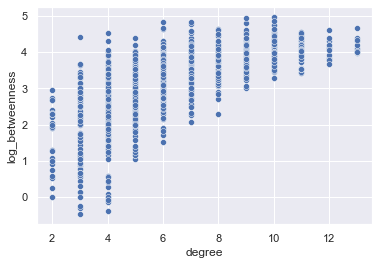

In [21]:
sns.scatterplot(data = df_graph_features, x="degree", y="log_betweenness")
plt.show()

We can clearly see the **LDLB**, **LDHB** and **HDHB** regions (using the log betweenness is clearly better, so we'll keep using it). Let's try to identify them...

None    1202
HDHB      63
LDLB      34
LDHB      19
Name: criticality, dtype: int64

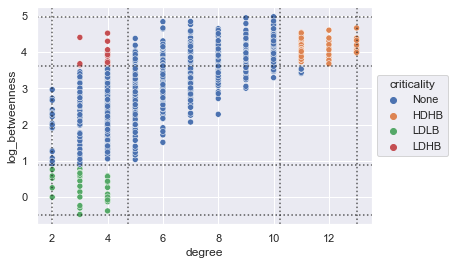

In [22]:
df_graph_features, lb_intervals, degree_intervals = calc_criticality(df_graph_features, 
                                                                     n_bins=4, 
                                                                     kind="uniform")

plot_criticality(df_graph_features, lb_intervals, degree_intervals)

In [23]:
lb_intervals

[Interval(-0.484, 0.886, closed='right'),
 Interval(0.886, 2.25, closed='right'),
 Interval(2.25, 3.613, closed='right'),
 Interval(3.613, 4.977, closed='right')]

In [24]:
degree_intervals

[Interval(1.9880000000000002, 4.75, closed='right'),
 Interval(4.75, 7.5, closed='right'),
 Interval(7.5, 10.25, closed='right'),
 Interval(10.25, 13.0, closed='right')]

### Supercritical nodes: those in Pareto front

In [25]:
df_graph_features = calc_supercrit(df_graph_features)

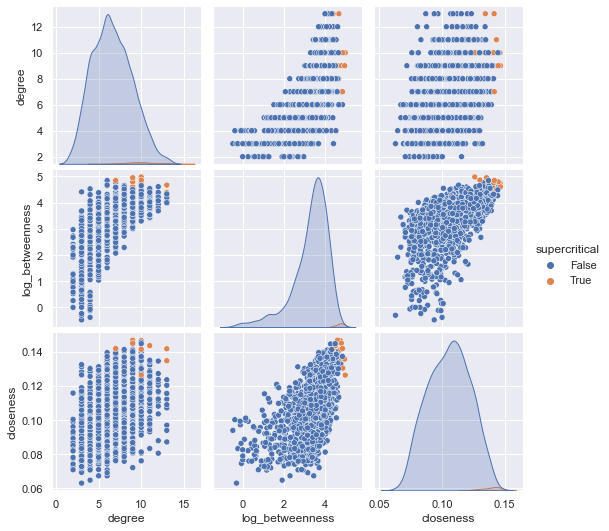

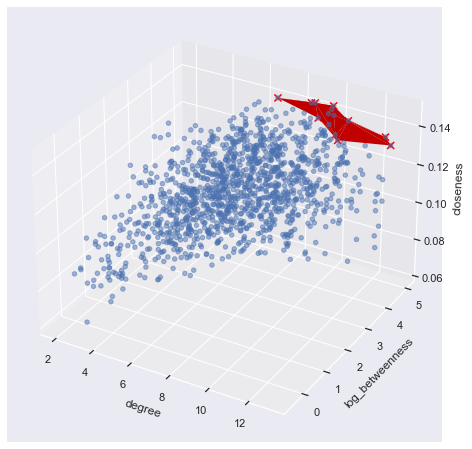

In [26]:
plot_pareto_front(df_graph_features, 
                  x_plot="degree", y_plot="log_betweenness", z_plot="closeness", 
                  pairplot=True, plot_3d=True)

In [27]:
df_graph_features = calc_criticality_super(df_graph_features)

display(df_graph_features["criticality"].value_counts())

display(df_graph_features["criticality_super"].value_counts())

None    1202
HDHB      63
LDLB      34
LDHB      19
Name: criticality, dtype: int64

None    1194
HDHB      63
LDLB      34
LDHB      19
SC         8
Name: criticality_super, dtype: int64

## Analysing critical residues

### Supercritical

In [28]:
print(df_graph_features.query("supercritical")["node"].tolist())

[1854, 1801, 1743, 1745, 1814, 1836, 1872, 1873, 1837, 1944, 618]


In [29]:
supercritical_pos = df_graph_features.query("criticality_super == 'SC'")["node"].tolist()

supercritical_name = df_conservation[df_conservation[" POS"].isin(supercritical_pos)]["3LATOM"].tolist()

print(f"{len(supercritical_name)} supercritical residues:")
print(*[x.capitalize() for x in supercritical_name], sep=", ")

8 supercritical residues:
Met618, Phe1745, Val1814, Leu1836, Leu1837, Phe1872, Leu1873, Ile1944


### LDLB

In [30]:
print(df_graph_features.query("criticality == 'LDLB'")["node"].tolist())

[117, 1537, 1549, 1546, 1548, 1575, 1602, 1675, 1661, 173, 1730, 1765, 198, 2048, 2063, 2182, 2118, 2154, 2134, 2145, 28, 314, 361, 356, 375, 435, 438, 536, 543, 550, 657, 663, 680, 700]


### LDHB

In [31]:
print(df_graph_features.query("criticality == 'LDHB'")["node"].tolist())

[2196, 1605, 31, 1985, 1987, 1807, 251, 2194, 19, 1931, 1996, 1978, 20, 2163, 306, 464, 392, 683, 673]


### HDHB

In [32]:
print(df_graph_features.query("criticality == 'HDHB'")["node"].tolist())

[1854, 111, 36, 38, 82, 74, 39, 124, 84, 91, 35, 163, 232, 144, 154, 1631, 1629, 190, 1556, 1632, 1592, 1563, 1565, 1640, 1703, 209, 1612, 1721, 1711, 1654, 1700, 1669, 633, 601, 1801, 1743, 227, 241, 1890, 1910, 1920, 1965, 287, 2097, 2095, 2180, 2105, 2125, 2150, 326, 368, 530, 335, 347, 415, 477, 478, 496, 487, 584, 520, 643, 603]


## Dataset for the full rin + residues' attributes + conservation score

In [33]:
# full rin, residues' attributes and conservation score

bring_only_consv = [' POS', 'SCORE']

df_full = (df_graph_features.merge(df_structure, left_on="node", right_on="number", how="inner")
                            .merge(df_conservation[bring_only_consv], left_on="node", right_on=' POS'))

keys = ['node', ' POS', 'number']

df_full = df_full[keys + [x for x in df_full.columns if x not in keys]].copy()

print(f"\nShape of data: {df_full.shape}")

##########################

assert(df_graph_features.shape[0] == df_full.shape[0])


Shape of data: (1318, 21)


### SASA and criticality

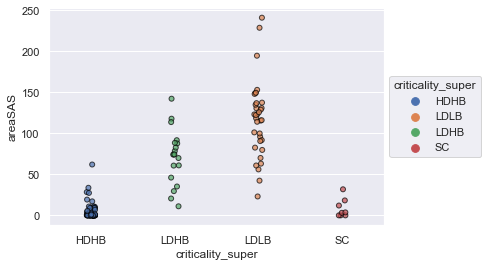

In [34]:
palette = np.repeat(np.array(sns.color_palette("deep")),1,axis=0)

ax = sns.stripplot(data = df_full.query("criticality_super != 'None'"),
                   x="criticality_super", y="areaSAS", hue="criticality_super",
                   edgecolor="black", alpha=.7, s=5, linewidth=1.0, jitter=0.05,
                   order="HDHB LDHB LDLB SC".split(), palette=palette)

ax.legend(handles=ax.legend_.legendHandles, 
          labels=[t.get_text() for t in ax.legend_.texts],
          title=ax.legend_.get_title().get_text(),
          bbox_to_anchor=(1, 0.5), loc="center left")

plt.savefig(f"{results_figs_path}/criticality_sasa_swarm.svg", format="svg", bbox_inches='tight')

plt.show()

In [35]:
df_full.query("criticality_super != 'None'").groupby("criticality_super")[["areaSAS"]].agg(["mean", "median", "min", "max"])

areaSAS                                   
                         mean      median        min         max
criticality_super                                               
HDHB                 4.777726    0.135473   0.000000   62.021201
LDHB                71.565301   74.296065  11.060526  142.272525
LDLB               117.062924  120.365684  23.056751  241.062564
SC                   8.597272    3.372767   0.000000   31.801072

### SCORE and criticality

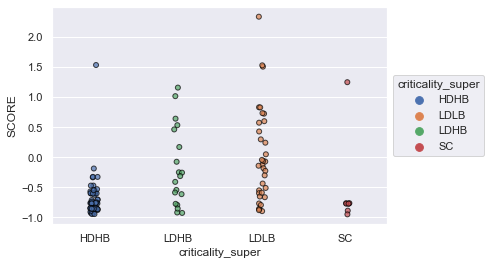

In [36]:
palette = np.repeat(np.array(sns.color_palette("deep")),1,axis=0)

ax = sns.stripplot(data = df_full.query("criticality_super != 'None'"),
                   x="criticality_super", y="SCORE", hue="criticality_super",
                   edgecolor="black", alpha=.7, s=5, linewidth=1.0, jitter=0.05,
                   order="HDHB LDHB LDLB SC".split(), palette=palette)

ax.legend(handles=ax.legend_.legendHandles, 
          labels=[t.get_text() for t in ax.legend_.texts],
          title=ax.legend_.get_title().get_text(),
          bbox_to_anchor=(1, 0.5), loc="center left")

plt.savefig(f"{results_figs_path}/criticality_score_swarm.svg", format="svg", bbox_inches='tight')

plt.show()

___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
___________
